<a href="https://colab.research.google.com/github/fikrifaizz/hr-attrition-optimizer/blob/main/notebooks/modeling_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
df = pd.read_parquet("../data/processed/hr_cleaned.parquet")
X = df.drop(columns=['attrition'])
y = df['attrition']
X_encoded = pd.get_dummies(X, drop_first=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Rasio Imbalance (Neg/Pos): {ratio:.2f}")

param_grid = {
    'max_depth': [3, 5, 7],         
    'learning_rate': [0.01, 0.1],     
    'n_estimators': [100, 200],       
    'scale_pos_weight': [ratio, ratio * 1.5], 
    'subsample': [0.8]                
}

Rasio Imbalance (Neg/Pos): 5.19


In [5]:
xgb_base = XGBClassifier(
    random_state=42, 
    eval_metric='logloss',
    n_jobs=-1  
)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring='recall', 
    verbose=1
)

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

print("\n--- HASIL TUNING XGBOOST ---")
print(f"Parameter Terbaik: {grid_search.best_params_}")
print(f"Recall Terbaik (CV): {grid_search.best_score_:.2%}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits

--- HASIL TUNING XGBOOST ---
Parameter Terbaik: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': np.float64(7.784210526315789), 'subsample': 0.8}
Recall Terbaik (CV): 72.61%


In [6]:
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

print("\n--- FINAL REPORT (TEST SET) ---")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob):.4f}")


--- FINAL REPORT (TEST SET) ---
              precision    recall  f1-score   support

           0       0.94      0.57      0.71       247
           1       0.26      0.81      0.40        47

    accuracy                           0.61       294
   macro avg       0.60      0.69      0.55       294
weighted avg       0.83      0.61      0.66       294

AUC-ROC Score: 0.7662


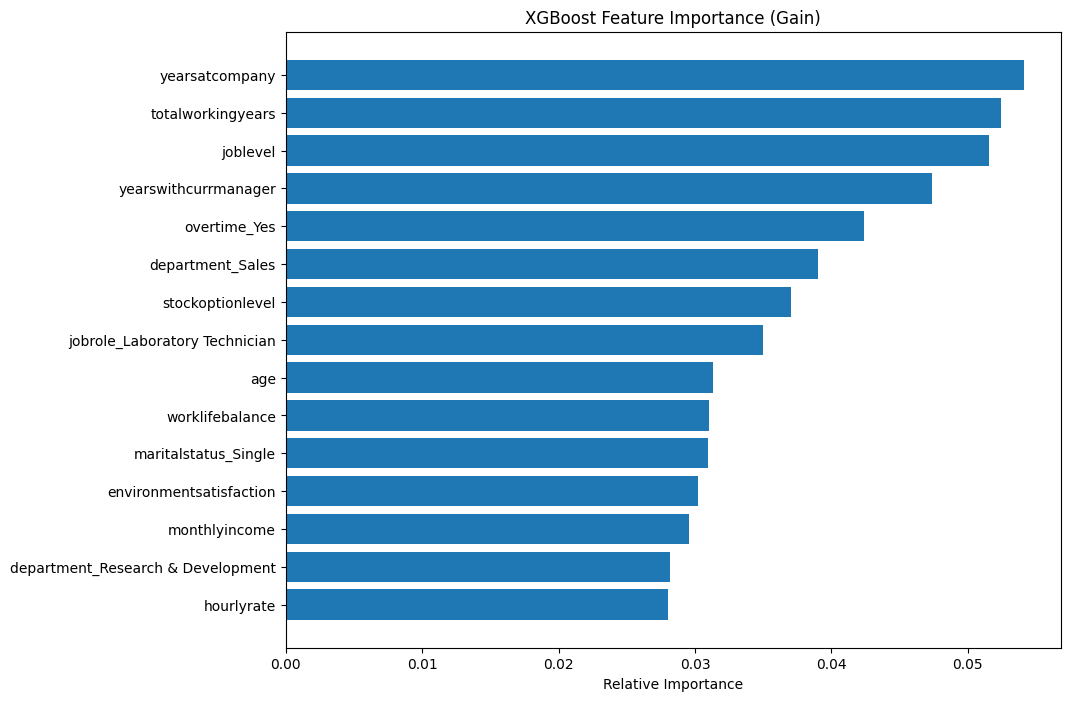

In [7]:
plt.figure(figsize=(10, 8))
sorted_idx = best_xgb.feature_importances_.argsort()
plt.barh(X_encoded.columns[sorted_idx][-15:], best_xgb.feature_importances_[sorted_idx][-15:])
plt.title("XGBoost Feature Importance (Gain)")
plt.xlabel("Relative Importance")
plt.show()